In [75]:
import os
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve
from scipy.ndimage import generate_binary_structure, label
from scipy.ndimage import sum as ndimage_sum

from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std

from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder


#f_name = "./ref_FS001_121011_1_J.fits"
f_name = "./ref_FS014_151219_1_J.fits"
#f_name = "./ref_FS017_120106_1_J.fits"



# satelita

def add_satellite(img, length=50, width=1, flux=10000, sigma=2.0):
    nx,ny = img.shape
    x0 = np.random.randint(0, nx)
    y0 = np.random.randint(0, ny)
    angle = np.random.uniform(0, np.pi)

    x = np.arange(nx)
    y = np.arange(ny)
    Y, X = np.meshgrid(np.arange(nx), np.arange(ny), indexing='ij')

    # Linie proste w kierunku angle
    dx = np.cos(angle)
    dy = np.sin(angle)

    # Wyznacz odległość punktów od linii satelity
    dist = ( (X - x0)*dy - (Y - y0)*dx )  # równoległe
    along = ( (X - x0)*dx + (Y - y0)*dy )  # wzdłuż

    # maska: pas o długości `length`, szerokości `width`
    mask = (np.abs(dist) < width) & (np.abs(along) < length / 2)

    temp = np.zeros_like(img, dtype=float)
    temp[mask] = flux

    return img + gaussian_filter(temp, sigma=sigma)


# cosmic ray

def add_cosmic_ray(img, n_segments=3, flux=30000, thickness=1):
    nx,ny = img.shape
    temp = np.zeros_like(img, dtype=float)
    x,y = np.random.randint(10, nx - 10), np.random.randint(10, ny - 10)

    for _ in range(n_segments):
        dx = np.random.randint(-5, 6)
        dy = np.random.randint(-5, 6)
        x_new = np.clip(x + dx, 0, nx - 1)
        y_new = np.clip(y + dy, 0, ny - 1)

        # Prostokąt o grubości `thickness`
        for i in range(-thickness, thickness + 1):
            for j in range(-thickness, thickness + 1):
                xi = np.clip(int(x_new + i), 0, nx - 1)
                yi = np.clip(int(y_new + j), 0, ny - 1)
                temp[yi, xi] += flux

        x, y = x_new, y_new

    return img + temp


In [76]:
hdul = fits.open(f_name)
image = hdul[0].data
header = hdul[0].header
hdul.close()


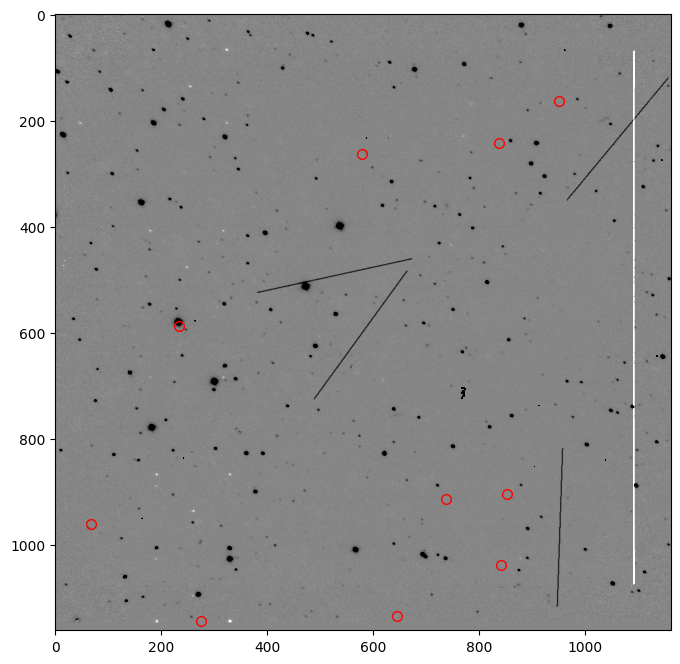

In [77]:
# dodanie hot pikseli, satelity i cosmic rayow

np.random.seed(18)

hot_piksels = Table(names=('x', 'y', 'flux'), dtype=(int, int, float))

flux = 5000
for _ in range(10):
    x = np.random.randint(0, image.shape[0])
    y = np.random.randint(0, image.shape[1])
    hot_piksels.add_row((x, y, flux))
    image[x,y] = image[x,y] + flux

# satelita

image = add_satellite(image, length=300, width=1, flux=100, sigma=0.5)

# xosmic ray

image = add_cosmic_ray(image, n_segments=10, flux=500, thickness=1)

np.random.seed(1)
image = add_satellite(image, length=300, width=1, flux=100, sigma=0.5)

np.random.seed(2)
image = add_satellite(image, length=300, width=1, flux=100, sigma=0.5)

np.random.seed(3)
image = add_satellite(image, length=300, width=1, flux=100, sigma=0.5)



# rysowanie

x_hot = hot_piksels["x"].data
y_hot = hot_piksels["y"].data

vmin = np.median(image)  - 1 * np.std(image)
vmax = np.median(image)  + 1 * np.std(image)

plt.figure(figsize=(8, 8))
plt.imshow(image,vmin=vmin+5,vmax=vmax+5,cmap='binary')
plt.plot(x_hot, y_hot, 'o', markerfacecolor='none', markeredgecolor='red', markersize=7)
plt.show()

In [78]:
def line_detection_kernel(R):
    size = 2 * R + 1
    center = R
    y, x = np.ogrid[:size, :size]
    distance = np.sqrt((x - center)**2 + (y - center)**2)
    inner = R - 1 / 2
    outer = R + 1 / 2

    left = ((x <= center) & (y <= center)) | ((x >= center) & (y >= center))
    right = ((x < center) & (y > center)) | ((x > center) & (y < center))
    
    #left
    mk = ((distance >= inner) & (distance <= outer))
    kernel_l = mk.astype(float)
    s = np.sum(mk)
    w = np.sum(~mk)
    #kernel_l[~mk] = -1 * (s/2) / (w - s - 1)
    #kernel_l[center,center]= 2
    tmp_mk = ((distance >= inner) & (distance <= outer) & right)
    kernel_l[tmp_mk] = -1
    
    #right
    mk = ((distance >= inner) & (distance <= outer))
    kernel_r = mk.astype(float)
    s = np.sum(mk)
    w = np.sum(~mk)
    #kernel_r[~mk] = -1 * (s/2) / (w - s - 1)
    #kernel_r[center,center]= 2
    tmp_mk = ((distance >= inner) & (distance <= outer) & left)
    kernel_r[tmp_mk] = -1

    return kernel_l, kernel_r



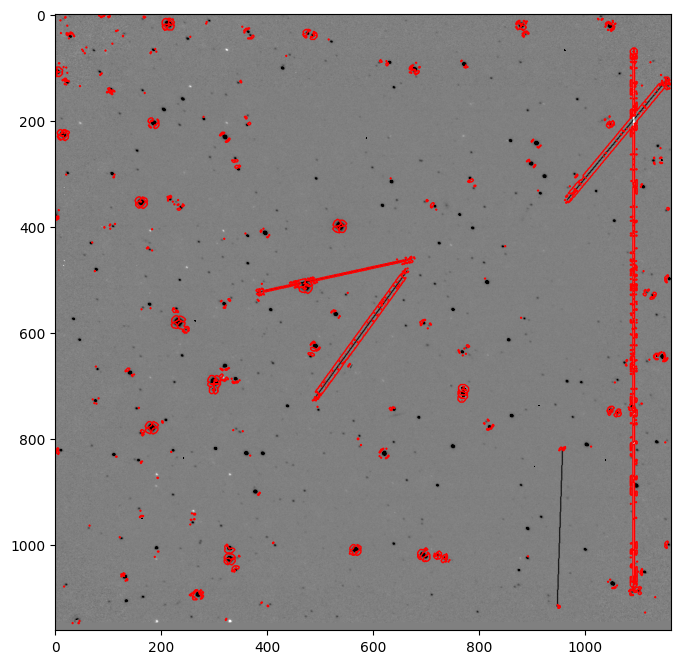

In [84]:
# filtr satelitow

kernel_sobel1 = [[-1,0,1],
                  [-2,0,2],
                  [-1,0,1]]

kernel_sobel2 = [[-1,-2,-1],
                  [0,0,0],
                  [1,2,-1]]

result_s1 = convolve(image, kernel_sobel1)
maska_ud = result_s1 > np.median(result_s1) + 100

result_s2 = convolve(image, kernel_sobel2)
maska_lr = result_s2 > np.median(result_s2) + 100

maska_sobel = maska_ud | maska_lr


kernel_l,kernel_r = line_detection_kernel(5) # tu sie zmienia


result_l = convolve(image, kernel_l)
maska_l = result_l > np.median(result_l) + 5 * mad_std(result_r)

result_r = convolve(image, kernel_r)
maska_r = result_r > np.median(result_r) + 5 * mad_std(result_r)

small_l = result_l
small_r = result_r

maska1 = maska_l ^ maska_r

kernel_l,kernel_r = line_detection_kernel(15) # tu sie zmienia

result_l = convolve(image, kernel_l)
maska_l = result_l > np.median(result_l) + 5 * mad_std(result_r)

result_r = convolve(image, kernel_r)
maska_r = result_r > np.median(result_r) + 5 * mad_std(result_r)

big_l = result_l
big_r = result_r

maska2 = maska_l ^ maska_r


maska = maska1 & maska2 # & maska_sobel


# znajdowanie grup

conection_kernel = generate_binary_structure(2, 2) # kernel grupowania
labeled_array, num_features = label(maska, structure=conection_kernel)
sizes = ndimage_sum(maska, labeled_array, range(1, num_features + 1))

maska0 = np.zeros_like(image, dtype=bool)

for i in range(1, num_features + 1):
    tmp = np.argwhere(labeled_array == i)
    pixels = []
    values = []
    if len(tmp) > 10: 
        for pk in tmp:
            pixels.append(pk)
            values.append(image[pk[1],pk[0]])
        pixels = np.array(pixels)
        values = np.array(values)
        mask = values > 0
        pixels = pixels[mask]
        values = values[mask]  
        if len(values) > 1:
            y_cen = np.average(pixels[:, 0], weights=values)
            x_cen = np.average(pixels[:, 1], weights=values)
            centered = pixels - [y_cen, x_cen]
            cov = np.cov(centered.T, aweights=values)
            eigvals, eigvecs = np.linalg.eigh(cov)  # [minor, major]
            major_axis = eigvecs[:, 1]
            minor_axis = eigvecs[:, 0]
            if eigvals[0] != 0:
                ellipticity = eigvals[1] / eigvals[0]  # >1 = wydłużony, ~1 = okrągły
    
                if ellipticity > 2:
                    for ay,ax in tmp:
                        maska0[ay,ax] = True
        

vmin = np.median(image)  - 1 * np.std(image)
vmax = np.median(image)  + 1 * np.std(image)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(image,vmin=vmin,vmax=vmax,cmap='binary')
X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
countours = ax.contour(X, Y, maska, 0, colors='red', linewidths=1) ##linewidth parameter had to be adjusted by eye estimation.

plt.show()


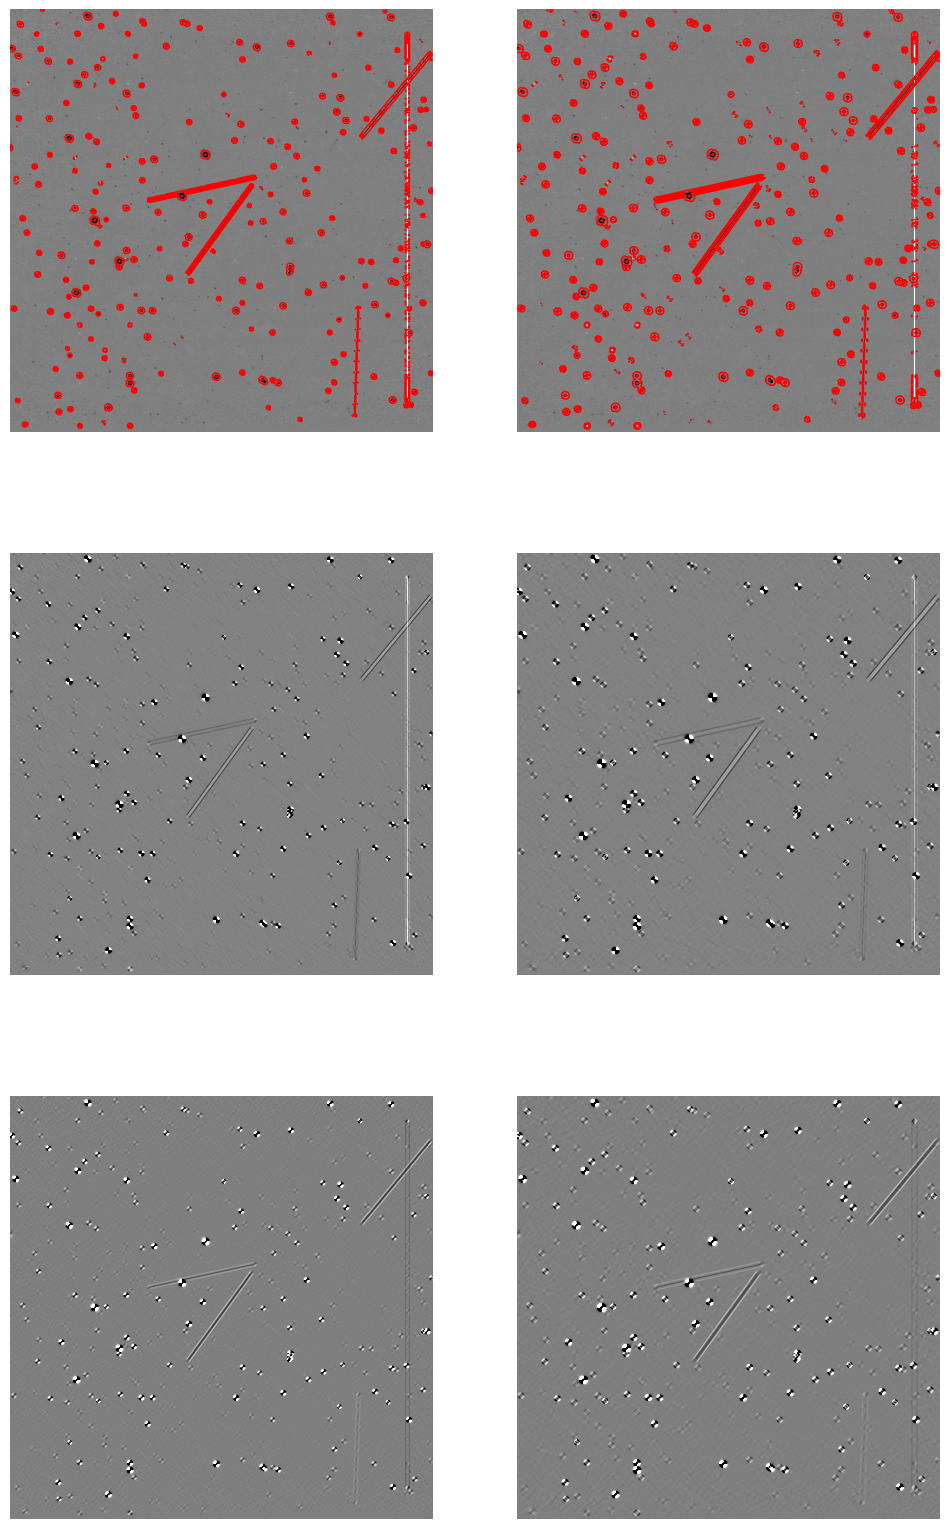

In [7]:
fig, ax = plt.subplots(3, 2, figsize=(12, 20))

vmin = np.median(image)  - 1 * np.std(image)
vmax = np.median(image)  + 1 * np.std(image)
ax[0][0].imshow(image,vmin=vmin,vmax=vmax,cmap='binary')
X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
countours = ax[0][0].contour(X, Y, maska1, 0, colors='red', linewidths=1) 
ax[0][0].axis('off')

vmin = np.median(image)  - 1 * np.std(image)
vmax = np.median(image)  + 1 * np.std(image)
ax[0][1].imshow(image,vmin=vmin,vmax=vmax,cmap='binary')
X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
countours = ax[0][1].contour(X, Y, maska2, 0, colors='red', linewidths=1) 
ax[0][1].axis('off')

vmin = np.mean(small_l) - 1 * np.std(small_l)
vmax = np.mean(small_l) + 1 * np.std(small_l) 
ax[1][0].imshow(small_l,vmin=vmin,vmax=vmax,cmap='binary')
ax[1][0].axis('off')

vmin = np.mean(small_r) - 1 * np.std(small_r)
vmax = np.mean(small_r) + 1 * np.std(small_r) 
ax[2][0].imshow(small_r,vmin=vmin,vmax=vmax,cmap='binary')
ax[2][0].axis('off')

vmin = np.mean(big_l) - 1 * np.std(big_l)
vmax = np.mean(big_l) + 1 * np.std(big_l) 
ax[1][1].imshow(big_l,vmin=vmin,vmax=vmax,cmap='binary')
ax[1][1].axis('off')

vmin = np.mean(big_r) - 1 * np.std(big_r)
vmax = np.mean(big_r) + 1 * np.std(big_r) 
ax[2][1].imshow(big_r,vmin=vmin,vmax=vmax,cmap='binary')
ax[2][1].axis('off')

plt.show()